In [1]:
import os
import faiss
import numpy as np
from PIL import Image
from glob import glob
from typing import Union, List
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

c:\Users\akshanb\AppData\Local\miniconda3\envs\research\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [7]:
image_folder = '../images'
index_path = './image_indexes.index'
model = SentenceTransformer('clip-ViT-B-32')

In [3]:
def get_image_paths(images_path: str):
    image_patterns = ['.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp']

    image_paths = []
    for filename in os.listdir(images_path):
        ext = os.path.splitext(filename)[1].lower()
        
        if ext in image_patterns:
            full_path = os.path.join(images_path, filename)
            image_paths.append(full_path)
    
    return image_paths

In [4]:
def generate_embeddings(images_path: str) -> Union[List, str]:
    image_paths = get_image_paths(images_path)

    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)

        embedding = model.encode(image)
        embeddings.append(embedding)

    return embeddings, image_paths

embeddings, image_paths = generate_embeddings(image_folder)

In [8]:
def create_faiss_index(embeddings: list, image_paths: str, output_path: str):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    faiss.write_index(index, output_path)

    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')


    return index

index = create_faiss_index(embeddings, image_paths, index_path)

In [9]:
def load_faiss_index(index_path: str):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]

    return index, image_paths

index, image_paths = load_faiss_index(index_path)

In [13]:
def retrieve_images(model, index, query: str, image_paths: str, top_k: int):
    
    query_embeddings = model.encode(query)
    query_embeddings = query_embeddings.astype(np.float32).reshape(1,-1)

    distances, indices = index.search(query_embeddings, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [14]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
    plt.axis('off')
    start_idx = 2

    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

Test

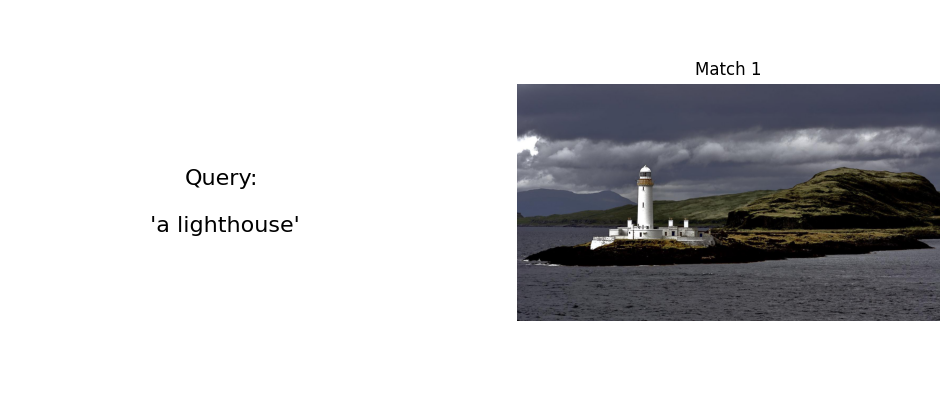

In [26]:
query = 'a lighthouse'
query, retrieved_images = retrieve_images(model, index, query, image_paths, top_k=1)
visualize_results(query, retrieved_images)